In [9]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import zstandard as zstd
from matplotlib.patches import Patch
from adjustText import adjust_text
import os

In [10]:
os.chdir("/home/lucytian/data/1_Single_Cell_PRS/2_cV2F")

In [11]:
annot = pd.read_csv('ukb_genoHM3_mvp_afr_tissue_cV2F.annot.pvar.gz', sep='\t', compression='gzip', low_memory=False)
pheno_name_dict = {'INI30120' : 'Lymphocyte Count', 'INI50030700': 'eGFR', 'INI1003063': 'FEV1 FVC_ratio', 'INI20030780': 'LDL-C'}

In [12]:
def divide_into_bins(data, n_bins=10):
    # Sort the data
    #sorted_data = sorted(data)
    
    # Calculate the size of each bin
    total_items = len(data)
    bin_size = total_items // n_bins
    
    # The number of bins that will have an extra item due to remainder
    remainder = total_items % n_bins
    
    bins = []
    start_index = 0
    for i in range(n_bins):
        # Bins that account for the remainder will have one extra item
        end_index = start_index + bin_size + (1 if i < remainder else 0)
        bins.append(data[start_index:end_index])
        start_index = end_index
    
    return bins

In [13]:
base_d = 'baselines/406k_geno_v2_UKB_18PCs/fit_w_val/'
data_d = 'mvp_afr_0.9_0.01/20231221/406k_geno_v2_UKB_18PCs/fit_w_val/'

In [14]:
cutoffs = {'BLOOD': 0.7324814022, 'LIVER': 0.6460890472, 'LUNG': 0.6198484063, 'KIDNEY': 0.619365716}
tissue_trait_dict = {'INI30120' : 'BLOOD', 'INI50030700': 'KIDNEY', 'INI1003063': 'LUNG', 'INI20030780': 'LIVER'}

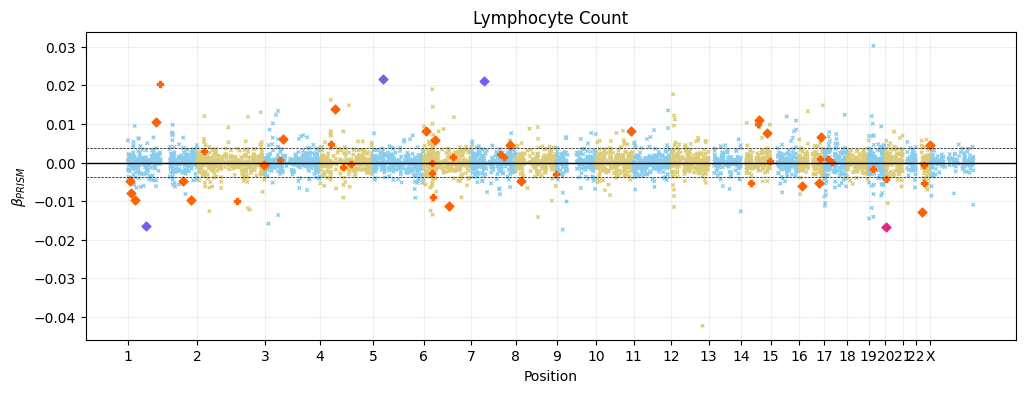

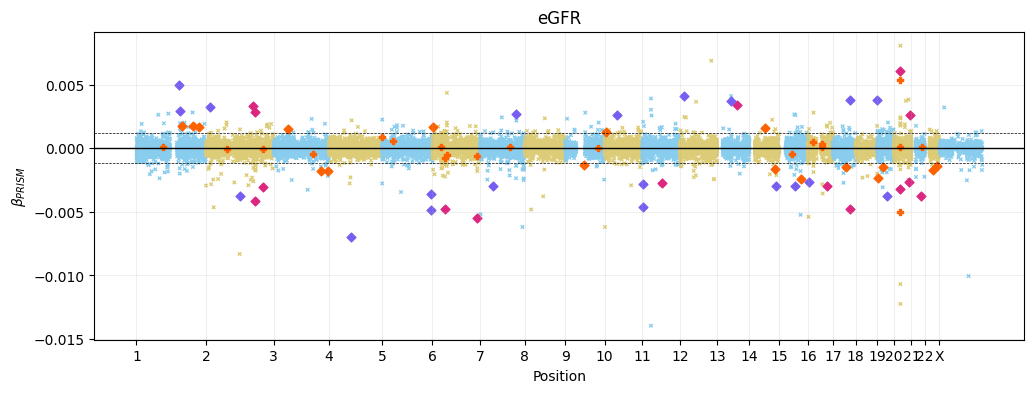

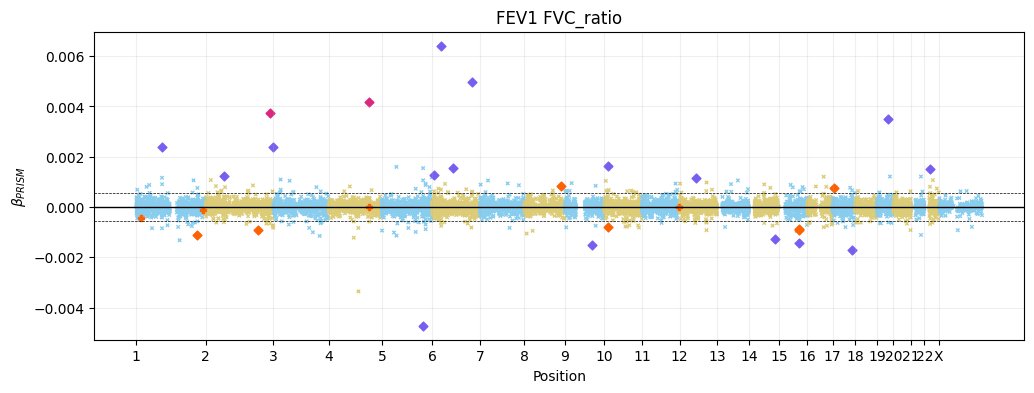

In [16]:
for tr in ['INI30120', 'INI50030700', 'INI1003063']:
    if tr == 'INI1003063':
        grouping = pd.read_csv(f'FEV1_FVC ratio_SNPs.tsv', sep='\t')
    else:
        grouping = pd.read_csv(f'{pheno_name_dict[tr]}_SNPs.tsv', sep='\t')
    df_beta = pd.read_csv(data_d + tissue_trait_dict[tr] + '/' + tr + '/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
    df_beta = df_beta.iloc[23:, :]
    df_beta_base = pd.read_csv(base_d + tr + '/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
    df_beta_base = df_beta_base.iloc[23:, :]

    merged = df_beta_base.merge(df_beta, on='#ID', how='outer')
    merged = merged.merge(annot[['#CHROM', 'POS', 'rsID', 'ID', f'cV2F_{tissue_trait_dict[tr]}']], left_on='#ID', right_on='ID')
    merged = merged[merged['#CHROM'] != 'MT']
    merged['#CHROM'] = merged['#CHROM'].replace('X', 23)
    merged['#CHROM'] = merged['#CHROM'].astype(int)
    merged = merged.sort_values(by=['#CHROM', 'POS'])

    merged[f'cV2F_{tissue_trait_dict[tr]}'] = merged[f'cV2F_{tissue_trait_dict[tr]}'].fillna(0)
    merged['BETA_x'] = merged['BETA_x'].fillna(0)
    merged['BETA_y'] = merged['BETA_y'].fillna(0)
    merged = merged.rename(columns={'BETA_x': 'Baseline', 'BETA_y': 'PRISM'})


    pos_max_dict = merged[['#CHROM', 'POS']].groupby('#CHROM').max()['POS'].to_dict()
    pos_max_dict[0] = 0
    pos_max_dict = dict(sorted(pos_max_dict.items()))
    pos_dic = {}
    pos_start = 0
    for i in np.arange(1, 24):
        pos_start += pos_max_dict[i - 1]
        pos_dic[i] = pos_start


    merged['DIFF'] = merged['PRISM'] - merged['Baseline']
    min_val = min(min(merged['Baseline']), min(merged['PRISM']))
    max_val = max(max(merged['PRISM']), max(merged['PRISM']))
    increment = (max_val - min_val) / 10

    merged = merged.merge(grouping[['#ID', 'group']], on='#ID')
    g2 = merged[merged['group'] == 'beta_deviation']
    not_prioritized = g2[g2[f'cV2F_{tissue_trait_dict[tr]}'] < cutoffs[tissue_trait_dict[tr]]].index.tolist()

    plt.figure(figsize=(12, 4))
    #x = merged['PRISM'].tolist()
    x_1 = merged['#CHROM'].tolist()
    x_cv2f = merged[f'cV2F_{tissue_trait_dict[tr]}'].tolist()
    x_2 = merged['POS'].tolist()
    y = merged['PRISM'].tolist()
    ids = merged['rsID'].tolist()
    x_plot = [j + pos_dic[i] for (i, j) in zip(x_1, x_2)]
    filter_index = merged[(merged['group'] == 'beta_deviation') | (merged['group'] == 'overlap') | ((merged['group'] == 'cV2F_prioritized')) | merged['A1_x'].isna() | merged['A1_y'].isna()].index.tolist()
    x_filtered = [x_plot[k] for k in np.arange(len(x_plot)) if k not in filter_index]
    x_1_filtered = [x_1[k] for k in np.arange(len(x_1)) if k not in filter_index]
    y_filtered = [y[k] for k in np.arange(len(y)) if k not in filter_index]
    color = ['#DDCC77' if i % 2 == 0 else '#88CCEE' for i in x_1_filtered]

    plt.axhline(y=increment/2, linestyle='--', color='black', linewidth=0.5)
    plt.axhline(y=-increment/2, linestyle='--', color='black', linewidth=0.5)

    g1_index = merged[(merged['group'] == 'beta_deviation')].index.tolist()
    g1_index = [i for i in g1_index if i not in not_prioritized]
    g3_index = merged[(merged['group'] == 'overlap')].index.tolist()
    g4_index = merged[(merged['group'] == 'cV2F_prioritized')].index.tolist()



    group1_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in g1_index]
    group4_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in g4_index]
    group1_y = [y[k] for k in np.arange(len(y)) if k in g1_index]
    group3_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in g3_index]
    group3_y = [y[k] for k in np.arange(len(y)) if k in g3_index]
    group4_y = [y[k] for k in np.arange(len(y)) if k in g4_index]

    g2_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in not_prioritized]
    g2_y = [y[k] for k in np.arange(len(y)) if k in not_prioritized]

    plt.scatter(x=x_filtered, y=y_filtered, s=6, color=color, marker='x', linewidths=1);
    plt.scatter(x=group1_x, y=group1_y, s=20, color='#FE6100', marker='D', linewidths=1);
    plt.scatter(x=group3_x, y=group3_y, s=20, color='#DC267F', marker='D', linewidths=1);
    plt.scatter(x=g2_x, y=g2_y, s=20, color='#FE6100', marker='P', linewidths=1);
    plt.scatter(x=group4_x, y=group4_y, s=20, color='#785EF0', marker='D', linewidths=1)


    plt.axhline(y=0, color='black', linewidth=1)
    plt.xticks(list(pos_dic.values()), np.arange(1, 23).tolist() + ['X'])
    plt.grid(True, alpha=0.2)
    plt.title(pheno_name_dict[tr])
    plt.xlabel("Position");
    plt.ylabel(r"$\beta_{PRISM}$");

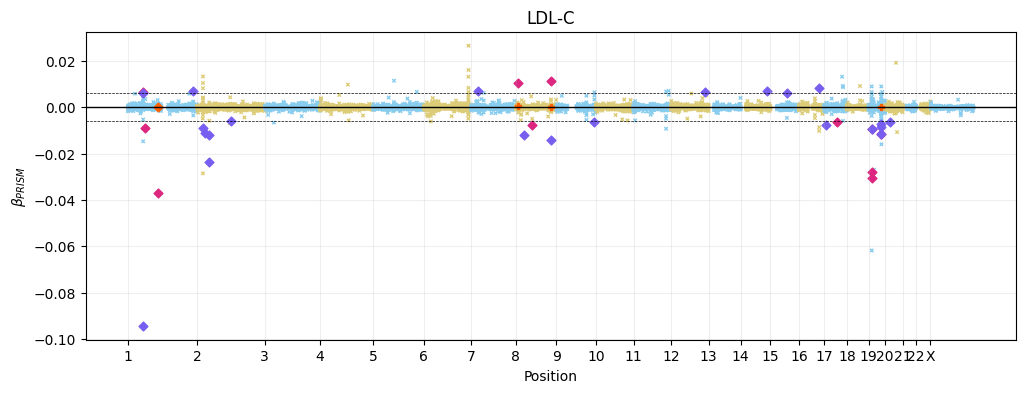

In [17]:
tr='INI20030780'
grouping = pd.read_csv('LDL-C_SNPs.tsv', sep='\t')
df_beta = pd.read_csv(data_d + 'LIVER' + '/' + tr + '/exclude_APOE/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
df_beta = df_beta.iloc[23:, :]
df_beta_base = pd.read_csv(base_d + tr + '/exclude_APOE/snpnet.BETAs.tsv.gz', sep='\t', compression='gzip')
df_beta_base = df_beta_base.iloc[23:, :]

merged = df_beta_base.merge(df_beta, on='#ID', how='outer')
merged = merged.merge(annot[['#CHROM', 'POS', 'rsID', 'ID', 'cV2F_LIVER']], left_on='#ID', right_on='ID')
merged = merged[merged['#CHROM'] != 'MT']
#merged = merged[merged['#CHROM'].isin([str(i) for i in np.arange(1, 23)])]
merged['#CHROM'] = merged['#CHROM'].replace('X', 23)
merged['#CHROM'] = merged['#CHROM'].astype(int)
#input_df = input_df.merge(afr_cV2F_penalty, on='#ID')
merged = merged.sort_values(by=['#CHROM', 'POS'])

merged['cV2F_LIVER'] = merged['cV2F_LIVER'].fillna(0)
merged['BETA_x'] = merged['BETA_x'].fillna(0)
merged['BETA_y'] = merged['BETA_y'].fillna(0)
merged = merged.rename(columns={'BETA_x': 'Baseline', 'BETA_y': 'PRISM'})


pos_max_dict = merged[['#CHROM', 'POS']].groupby('#CHROM').max()['POS'].to_dict()
pos_max_dict[0] = 0
pos_max_dict = dict(sorted(pos_max_dict.items()))
pos_dic = {}
pos_start = 0
for i in np.arange(1, 24):
    pos_start += pos_max_dict[i - 1]
    pos_dic[i] = pos_start


merged['DIFF'] = merged['PRISM'] - merged['Baseline']
min_val = min(min(merged['Baseline']), min(merged['PRISM']))
max_val = max(max(merged['PRISM']), max(merged['PRISM']))
increment = (max_val - min_val) / 10

merged = merged.merge(grouping[['#ID', 'group']], on='#ID')
g2 = merged[merged['group'] == 'beta_deviation']
not_prioritized = g2[g2['cV2F_LIVER'] < 0.6460890472].index.tolist()

plt.figure(figsize=(12, 4))
#x = merged['PRISM'].tolist()
x_1 = merged['#CHROM'].tolist()
x_cv2f = merged['cV2F_LIVER'].tolist()
x_2 = merged['POS'].tolist()
y = merged['PRISM'].tolist()
ids = merged['rsID'].tolist()
x_plot = [j + pos_dic[i] for (i, j) in zip(x_1, x_2)]
filter_index = merged[(merged['group'] == 'beta_deviation') | (merged['group'] == 'overlap') | ((merged['group'] == 'cV2F_prioritized')) | merged['A1_x'].isna() | merged['A1_y'].isna()].index.tolist()
x_filtered = [x_plot[k] for k in np.arange(len(x_plot)) if k not in filter_index]
x_1_filtered = [x_1[k] for k in np.arange(len(x_1)) if k not in filter_index]
y_filtered = [y[k] for k in np.arange(len(y)) if k not in filter_index]
color = ['#DDCC77' if i % 2 == 0 else '#88CCEE' for i in x_1_filtered]

plt.axhline(y=increment/2, linestyle='--', color='black', linewidth=0.5)
plt.axhline(y=-increment/2, linestyle='--', color='black', linewidth=0.5)

g1_index = merged[(merged['group'] == 'beta_deviation')].index.tolist()
g1_index = [i for i in g1_index if i not in not_prioritized]
g3_index = merged[(merged['group'] == 'overlap')].index.tolist()
g4_index = merged[(merged['group'] == 'cV2F_prioritized')].index.tolist()



group1_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in g1_index]
group4_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in g4_index]
group1_y = [y[k] for k in np.arange(len(y)) if k in g1_index]
group3_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in g3_index]
group3_y = [y[k] for k in np.arange(len(y)) if k in g3_index]
group4_y = [y[k] for k in np.arange(len(y)) if k in g4_index]

g2_x = [x_plot[k] for k in np.arange(len(x_plot)) if k in not_prioritized]
g2_y = [y[k] for k in np.arange(len(y)) if k in not_prioritized]

plt.scatter(x=x_filtered, y=y_filtered, s=6, color=color, marker='x', linewidths=1);
plt.scatter(x=group1_x, y=group1_y, s=20, color='#FE6100', marker='D', linewidths=1);
plt.scatter(x=group3_x, y=group3_y, s=20, color='#DC267F', marker='D', linewidths=1);
plt.scatter(x=g2_x, y=g2_y, s=20, color='#FE6100', marker='P', linewidths=1);
plt.scatter(x=group4_x, y=group4_y, s=20, color='#785EF0', marker='D', linewidths=1)


plt.axhline(y=0, color='black', linewidth=1)
plt.xticks(list(pos_dic.values()), np.arange(1, 23).tolist() + ['X'])
plt.grid(True, alpha=0.2)
plt.title(pheno_name_dict[tr])
plt.xlabel("Position");
plt.ylabel(r"$\beta_{PRISM}$");